<a href="https://colab.research.google.com/github/zia207/Deep-Neural-Network-Satellite-Image-Classification-in-Google-Colaboratory-iPython-Note-Book-/blob/master/NoteBook/Advance_Regression/02-04-03-03-multilevel-glm-ordinal-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3.3. Multilevel or Mixed Effects Ordinal Model

This tutorial introduces the concept of Multilevel or Mixed Effects Ordinal Models and their application in analyzing hierarchical data with ordinal outcomes. Multilevel ordinal models extend the framework of linear mixed-effects models to accommodate ordinal response variables with multiple levels. This tutorial covers the following topics:

## Overview

Mixed-Effects Ordinal Regression is a statistical technique used to model ordinal response variables (i.e., categorical variables with an inherent order) while accounting for both fixed effects (predictors of interest) and random effects (to capture variability due to hierarchical or grouped data structures, such as subjects, clusters, or repeated measures).

An ordinal variable $Y$ takes values $1, 2, \dots, K$ (where $K$ is the number of categories), with an implicit order but unknown spacing between categories.

The ordinal outcome is often modeled using a latent continuous variable $Y^*$:

$$ Y^* = X\beta + Zb + \epsilon$$ where

-   $Y^*$: Latent continuous variable.
-   $X$: Fixed effects design matrix.
-   $\beta$: Coefficients for fixed effects (population-level parameters).
-   $Z$: Random effects design matrix.
-   $b$: Random effects, typically assumed $b \sim N(0, \Sigma_b)$.
-   $\epsilon$: Error term, usually assumed $\epsilon \sim N(0, 1)$.

The observed ordinal response $Y$ is linked to $Y^*$ via thresholds:

$$ Y = k \quad \text{if } \tau_{k-1} < Y^* \leq \tau_k, \quad k = 1, \dots, K $$

where $\tau_0 = -\infty$ and $\tau_K = \infty$, and $\tau_1, \dots, \tau_{K-1}$ are estimated threshold parameters.

**Likelihood Function** can be defined as:

The probability of observing $Y = k$ is:

$$ P(Y = k \mid X, Z, \beta, b, \tau) = \Phi(\tau*k -* \eta) - \Phi(\tau{k-1} - \eta) $$

where: -

$\Phi$: Cumulative distribution function (CDF) of the standard normal distribution.

$\eta = X\beta + Zb$: Linear predictor incorporating fixed and random effects.

The joint likelihood incorporates both the fixed and random effects and their distributions.

-   Fixed Effects ($\beta$): Represent the impact of predictors on the ordinal outcome.

-   Random Effects ($b$): Account for variability between clusters (e.g., subjects, schools).

-   Thresholds ($\tau$): Define category boundaries.

Parameters are estimated using **maximum likelihood estimation (MLE)** or **Bayesian methods**.


## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp311-cp311-linux_x86_64.whl


## Mount Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Multilevel Ordinal Model from Scratch

Below is a step-by-step explanation of how to fit a multilevel ordinal model from scratch in R. I'll break it down into logical parts, matching the provided R script.


### Simulate Data

We create a dataset that mimics a multilevel ordinal outcome. Here's the logic:

1.  ***Hierarchical Structure***: Assume data is grouped into 20 clusters (e.g., patients nested in clinics), each with 50 observations.
2.  ***Random Effects***: Each group has a random intercept, drawn from a normal distribution with standard deviation $\sigma_b = 1$.
3.  ***Fixed Effect***: Simulate a predictor $x$, and let the true coefficient for $x$ $\beta$ be $0.5$.
4.  ***Ordinal Categories***: Define thresholds that split the latent variable $Y^*$ into ordered categories $Y$.


Here is the simulated setup:


In [6]:
%%R
# Step 1: Simulate Data
set.seed(123)

# Define the number of groups and observations per group
n_groups <- 20                # Number of groups (e.g., clinics)
n_obs_per_group <- 50         # Observations per group

# True parameters
beta <- 0.5                   # Fixed effect coefficient
sigma_b <- 1                  # Standard deviation of random intercepts
thresholds <- c(-1, 0, 1)     # Thresholds for ordinal categories

# Simulate random intercepts for groups
group_random_effects <- rnorm(n_groups, mean = 0, sd = sigma_b)

# Simulate data
data <- data.frame(
  group = rep(1:n_groups, each = n_obs_per_group),  # Group IDs
  x = rnorm(n_groups * n_obs_per_group)            # Predictor variable
)

# Generate the latent response Y* and ordinal response Y
data$eta <- beta * data$x + group_random_effects[data$group]
data$y_star <- data$eta + rnorm(nrow(data))  # Add individual noise
data$y <- cut(
  data$y_star,
  breaks = c(-Inf, thresholds, Inf),
  labels = 1:(length(thresholds) + 1),
  right = TRUE
)
data$y <- as.numeric(as.character(data$y))  # Convert factor to numeric
head(data)

  group          x        eta      y_star y
1     1 -1.0678237 -1.0943875 -1.25847750 1
2     1 -0.2179749 -0.6694631 -0.83238981 2
3     1 -1.0260044 -1.0734779  0.32509414 3
4     1 -0.7288912 -0.9249213 -0.02652502 2
5     1 -0.6250393 -0.8729953 -2.52149010 1
6     1 -1.6866933 -1.4038223 -1.17526533 1


### Define the Likelihood Function

The likelihood function combines:

***Fixed Effects***: Use $\beta \cdot X$) to model the population-level effect of the predictor.
***Random Effects***: Model the group-specific random intercepts $b_i$ using a normal distribution.
***Probit Link Function***: Use cumulative probabilities to map latent $Y^*$ into ordinal categories defined by thresholds.

The cumulative probabilities for each category $k$ are:

$$ P(Y = k \mid X, b) =
\begin{cases}
\Phi(\tau_k - \eta), & k = 1 \\
\Phi(\tau_k - \eta) - \Phi(\tau_{k-1} - \eta), & 2 \leq k \leq K - 1 \\
1 - \Phi(\tau_{k-1} - \eta), & k = K
\end{cases} $$

The function computes:
- Log-likelihood for observed data $Y$, given parameters ($\beta, \tau, b, \sigma_b$).
- Random effects prior, to incorporate their distribution.

In [5]:
%%R
log_likelihood <- function(params, data) {
  # Extract parameters
  beta <- params[1]
  sigma_b <- exp(params[2])  # Ensure positive variance
  thresholds <- params[3:(3 + length(thresholds) - 1)]
  random_effects <- params[(3 + length(thresholds)):length(params)]

  # Ensure thresholds are ordered
  if (!all(diff(thresholds) > 0)) {
    return(Inf)  # Penalize unordered thresholds
  }

  # Compute linear predictor
  eta <- beta * data$x + random_effects[data$group]

  # Compute category probabilities
  prob <- sapply(1:(length(thresholds) + 1), function(k) {
    if (k == 1) {
      pnorm(thresholds[k] - eta)
    } else if (k == (length(thresholds) + 1)) {
      1 - pnorm(thresholds[k - 1] - eta)
    } else {
      pnorm(thresholds[k] - eta) - pnorm(thresholds[k - 1] - eta)
    }
  })

  # Ensure probabilities are valid
  prob <- pmax(prob, .Machine$double.eps)  # Avoid log(0)

  # Log-likelihood for observed categories
  ll <- sum(log(prob[cbind(1:nrow(data), data$y)]))

  # Add random effects prior
  ll <- ll - sum(dnorm(random_effects, mean = 0, sd = sigma_b, log = TRUE))

  # Return negative log-likelihood
  return(-ll)
}


### Optimize the Model

We estimate the parameters by minimizing the negative log-likelihood using the `optim()` function.

- ***Initial Parameters***: Provide starting values for $\beta$, $\sigma_b$, thresholds, and random effects.
- ***Optimization Method***: Use "BFGS," a quasi-Newton optimization algorithm.
- ***Output***: The `optim()` result includes parameter estimates and convergence diagnostics.


In [6]:
%%R
# Improved initialization
init_thresholds <- seq(-2, 2, length.out = length(thresholds))
init_params <- c(0, log(1), init_thresholds, rep(0, n_groups))

# Optimization with bounds
opt <- optim(
  par = init_params,
  fn = log_likelihood,
  data = data,
  method = "L-BFGS-B",
  lower = c(-Inf, -10, rep(-Inf, length(thresholds)), rep(-3, n_groups)),  # Bounds for parameters
  upper = c(Inf, 10, rep(Inf, length(thresholds)), rep(3, n_groups)),
  control = list(maxit = 1000, trace = 6)
)

# Check optimization result
if (opt$convergence == 0) {
  cat("Optimization converged successfully.\n")
  print(opt$par)
} else {
  cat("Optimization did not converge.\n")
}


N = 25, M = 5 machine precision = 2.22045e-16
L = -inf -10 -inf -inf -inf -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 
X0 = 0 0 -2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
U = inf 10 inf inf inf 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       2252.2  |proj g|=       644.58
Iteration     0

---------------- CAUCHY entered-------------------

There are 21  breakpoints

Piece      1 f1, f2 at start point -1.0943e+06  1.0943e+06
Distance to the next break point =   3.0733e-02
Distance to the stationary point =   1.0000e+00
Variable  21  is fixed.

Piece      2 f1, f2 at start point -1.0514e+06  1.0848e+06
Distance to the next break point =   1.4996e-03
Distance to the stationary point =   9.6927e-01
Variable  11  is fixed.

Piece      3 f1, f2 at start point -1.0414e+06  1.0761e+06
Distance to the next break point =   1.8110e-03
Distance to the stationary point =   9.6777e-01
Variable  23  is fixed.

Piece

###   Model Summary

Extract and interpret the estimated parameters


***Fixed Effect*** ($\beta$): The estimated effect of the predictor.

***Random Effect SD*** ($\sigma_b$)**: Variability between groups.

***Thresholds*** ($\tau_k$): Category cutoffs in the latent space.

In [7]:
%%R
summary_params <- opt$par
names(summary_params) <- c("beta", "log(sigma_b)", paste0("tau", 1:length(thresholds)), paste0("b", 1:n_groups))
print(summary_params)

        beta log(sigma_b)         tau1         tau2         tau3           b1 
  0.58999576  10.00000000  -1.15325108  -0.17944477   0.84695589  -0.68034875 
          b2           b3           b4           b5           b6           b7 
 -0.46016006   1.29903528  -0.23153278   0.05302025   1.57572032   0.14231640 
          b8           b9          b10          b11          b12          b13 
 -1.33977745  -0.72172043  -0.50367996   1.21702961   0.23710687   0.30031996 
         b14          b15          b16          b17          b18          b19 
  0.03422832  -0.84029035   1.82165740   0.29986601  -1.94662160   0.46920635 
         b20 
 -0.73011163 


### Extract Parameter Estimates

The optim function stores optimized parameters in the par attribute of its output object. We extract the estimated parameters for further analysis.

In [8]:
%%R
# Extract optimized parameters
opt_params <- opt$par
est_beta <- opt_params[1]  # Extract beta (fixed effect)
est_log_sigma_b <- opt_params[2]  # Extract log(sigma_b)
est_thresholds <- opt_params[3:(3 + length(thresholds) - 1)]
est_random_effects <- opt_params[(3 + length(thresholds)):length(opt_params)]

# Print estimates
cat("Estimated Beta (fixed effect):", est_beta, "\n")
cat("Estimated Sigma_b (random intercept SD):", exp(est_log_sigma_b), "\n")
cat("Estimated Thresholds:", est_thresholds, "\n")
cat("Estimated Random Effects (first 5):", head(est_random_effects), "\n")

Estimated Beta (fixed effect): 0.5899958 
Estimated Sigma_b (random intercept SD): 22026.47 
Estimated Thresholds: -1.153251 -0.1794448 0.8469559 
Estimated Random Effects (first 5): -0.6803487 -0.4601601 1.299035 -0.2315328 0.05302025 1.57572 


###  Prediction and Evaluation

Using the estimated parameters:

1. Predict the most likely ordinal category for each observation.
2. Compare predictions to observed categories to compute a confusion matrix and accuracy.

In [9]:
%%R
data$eta_est <- est_beta * data$x + est_random_effects[data$group]
data$y_pred <- sapply(data$eta_est, function(eta) {
  probs <- c(
    pnorm(est_thresholds[1] - eta),
    diff(c(pnorm(est_thresholds - eta), 1))
  )
  which.max(probs)
})

# Confusion Matrix and Accuracy
conf_matrix <- table(Predicted = data$y_pred, Actual = data$y)
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)

print(conf_matrix)
cat(sprintf("Accuracy: %.2f%%\\n", accuracy * 100))

         Actual
Predicted   1   2   3   4
        1 127  72  22   4
        2  60  66  71  24
        3  28  75  87  66
        4   4  24  80 190
Accuracy: 47.00%\n

## Mixed-Effects Ordinal Model in R

In this section we will fit a mixed-effects ordinal regression model to the simulated data using the `clmm()` function from the {ordinal} package. The `clmm()` function fits cumulative link mixed models (CLMMs) to ordinal response data.  Fits cumulative link mixed models, i.e. cumulative link models with random effects via the `Laplace approximation` or the standard and the adaptive `Gauss-Hermite quadrature approximation`. Laplace approximation is the default method for fitting the model which plays a critical role in estimating the likelihood of the model by simplifying the integration over random effects. Mixed-effects models involve random effects to account for group-level variation, but these random effects introduce high-dimensional integrals into the likelihood function, making it computationally intractable to solve exactly. The Gauss-Hermite quadrature approximation is a numerical integration technique Gauss-Hermite quadrature is particularly well-suited for integrating over Gaussian random effect which is particularly useful for computing integrals involving a Gaussian density function, as it efficiently approximates the integral by using a weighted sum of function evaluations at specific points (nodes).

### Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:




In [7]:
%%R
packages <- c('tidyverse',
              'dlookr',
              'sjPlot',
              'ordinal')

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [8]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method          from  
  plot.transform  scales
  print.transform scales



tidyverse    dlookr    sjPlot   ordinal 
     TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [9]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages


Successfully loaded packages:
 [1] "package:ordinal"   "package:sjPlot"    "package:dlookr"   
 [4] "package:lubridate" "package:forcats"   "package:stringr"  
 [7] "package:dplyr"     "package:purrr"     "package:readr"    
[10] "package:tidyr"     "package:tibble"    "package:ggplot2"  
[13] "package:tidyverse" "package:tools"     "package:stats"    
[16] "package:graphics"  "package:grDevices" "package:utils"    
[19] "package:datasets"  "package:methods"   "package:base"     


### Data

The `soup` data from {ordinal} package has 1847 rows and 13 variables. 185 respondents participated in an A-not A discrimination test with sureness. Before experimentation the respondents were familiarized with the reference product and during experimentation, the respondents were asked to rate samples on an ordered scale with six categories given by combinations of (reference, not reference) and (sure, not sure, guess) from 'referene, sure' = 1 to 'not reference, sure' = 6. The data set contains the following variables:

`RESP`: factor with 185 levels: the respondents in the study.

`PROD`: factor with 2 levels: index reference and test products.

`PRODID`: factor with 6 levels: index reference and the five test product variants.

`SURENESS`: ordered factor with 6 levels: the respondents ratings of soup samples.

`DAY`:\` factor with two levels: experimentation was split over two days.

`SOUPTYPE`: factor with three levels: the type of soup regularly consumed by the respondent.

`SOUPFREQ`: factor with 3 levels: the frequency with which the respondent consumes soup.

`COLD`: factor with two levels: does the respondent have a cold?

`EASY`: factor with ten levels: How easy did the respondent find the discrimation test? 1 = difficult, 10 = easy.

`GENDER`: factor with two levels: gender of the respondent.

`AGEGROUP`: factor with four levels: the age of the respondent.

`LOCATION`: factor with three levels: three different locations where experimentation took place.



In [10]:
%%R
data(soup, lib = "ordinal")
mf<-as_tibble(soup)

In [11]:
%%R
soup$SURENESS <- factor(soup$SURENESS, levels = c("1", "2", "3", "4", "5", "6"), ordered = TRUE)
str(soup)

'data.frame':	1847 obs. of  12 variables:
 $ RESP    : Factor w/ 185 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ PROD    : Factor w/ 2 levels "Ref","Test": 1 2 1 2 1 2 2 2 2 1 ...
 $ PRODID  : Factor w/ 6 levels "1","2","3","4",..: 1 2 1 3 1 6 2 4 5 1 ...
 $ SURENESS: Ord.factor w/ 6 levels "1"<"2"<"3"<"4"<..: 6 5 5 6 5 5 2 5 5 2 ...
 $ DAY     : Factor w/ 2 levels "1","2": 1 1 1 1 2 2 2 2 2 2 ...
 $ SOUPTYPE: Factor w/ 3 levels "Self-made","Canned",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ SOUPFREQ: Factor w/ 3 levels ">1/week","1-4/month",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ COLD    : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 2 2 2 2 2 ...
 $ EASY    : Factor w/ 10 levels "1","2","3","4",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ GENDER  : Factor w/ 2 levels "Male","Female": 2 2 2 2 2 2 2 2 2 2 ...
 $ AGEGROUP: Factor w/ 4 levels "18-30","31-40",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ LOCATION: Factor w/ 3 levels "Region 1","Region 2",..: 1 1 1 1 1 1 1 1 1 1 ...


In [14]:
%%R
# then diagnose them
mf |>
dplyr::select(SURENESS, PROD, RESP, LOCATION)  |>
dlookr::diagnose_category()


# A tibble: 21 × 6
   variables levels     N  freq  ratio  rank
   <chr>     <chr>  <int> <int>  <dbl> <int>
 1 SURENESS  6       1847   869 47.0       1
 2 SURENESS  5       1847   277 15.0       2
 3 SURENESS  2       1847   260 14.1       3
 4 SURENESS  1       1847   228 12.3       4
 5 SURENESS  3       1847   115  6.23      5
 6 SURENESS  4       1847    98  5.31      6
 7 PROD      Test    1847  1108 60.0       1
 8 PROD      Ref     1847   739 40.0       2
 9 RESP      1       1847    10  0.541     1
10 RESP      2       1847    10  0.541     1
# ℹ 11 more rows
# ℹ Use `print(n = ...)` to see more rows


### Fit Mixed-Effects Ordinal Model

We fit a mixed-effects ordinal regression model to the `soup` data using the `clmm()` function from the `ordinal` package. The `clmm()` function fits cumulative link mixed models (CLMMs) to ordinal response data. CLMMs are an extension of generalized linear mixed models (GLMMs) to ordinal response data. The `clmm()` function allows you to specify both fixed and random effects in the model formula. The `link` argument specifies the link function to use, and the `threshold` argument specifies the type of threshold parameterization to use. The `Hess` argument specifies whether to compute the Hessian matrix for the model.

#### Ordinal Regression Model with Random Intercept

First we fit a cumulative link model with one random term (random intercept) to the `soup` data. The model predicts the `SURENESS` of soup samples based on the `RESP` variable (respondent ID) as a random effect. We use the `link = "probit"` argument to specify the probit link function and the `threshold = "equidistant"` argument to specify equidistant thresholds. We set `Hess = TRUE` to compute the Hessian matrix for the model.


In [15]:
%%R
## Cumulative link model with one random term:
m_01 <- clmm(SURENESS ~(1|RESP),
            link = "probit",
            threshold = "equidistant",
            Hess = TRUE,
            data = mf)
summary(m_01)

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: SURENESS ~ (1 | RESP)
data:    mf

 link   threshold   nobs logLik   AIC     niter    max.grad cond.H 
 probit equidistant 1847 -2860.32 5726.63 115(319) 3.38e-05 3.8e+02

Random effects:
 Groups Name        Variance Std.Dev.
 RESP   (Intercept) 0.08037  0.2835  
Number of groups:  RESP 185 

No Coefficients

Threshold coefficients:
             Estimate Std. Error z value
threshold.1 -1.128753   0.041359  -27.29
spacing      0.301646   0.009349   32.27


#### Ordinal Regression Model with Random Intercept and Fixed Effects

Then, we fit a cumulative link model with one random term (random intercept) and fixed effects to the `soup` data. The model predicts the `SURENESS` of soup samples based on the `PROD` and `GENDER` variables as fixed effects and the `RESP` variable (respondent ID) as a random effect. We use the `link = "probit"` argument to specify the probit link function and the `threshold = "equidistant"` argument to specify equidistant thresholds. We set `Hess = TRUE` to compute the Hessian matrix for the model.

In [16]:
%%R
## Cumulative link model with one random term and fixed effects:
m_02 <- clmm(SURENESS ~ PROD + GENDER + (1|RESP),
            link = "probit",
            threshold = "equidistant",
            Hess = TRUE,
            data = mf)
summary(m_02)

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: SURENESS ~ PROD + GENDER + (1 | RESP)
data:    mf

 link   threshold   nobs logLik   AIC     niter    max.grad cond.H 
 probit equidistant 1847 -2772.33 5554.66 245(770) 2.43e-03 2.6e+02

Random effects:
 Groups Name        Variance Std.Dev.
 RESP   (Intercept) 0.1079   0.3285  
Number of groups:  RESP 185 

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
PRODTest      0.71193    0.05392  13.204   <2e-16 ***
GENDERFemale -0.04028    0.07609  -0.529    0.597    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Threshold coefficients:
            Estimate Std. Error z value
threshold.1 -0.80991    0.07219  -11.22
spacing      0.32282    0.00995   32.44


#### Ordinal Regression Model with Two Random Terms and Fixed Effects

Lastly, we fit a cumulative link model with two random terms (random intercept and random slope) and fixed effects to the `soup` data. The model predicts the `SURENESS` of soup samples based on the `PROD` and `GENDER` variables as fixed effects and the `RESP` variable (respondent ID) and the interaction between `RESP` and `PROD` as random effects. We use the `link = "probit"` argument to specify the probit link function and the `threshold = "equidistant"` argument to specify equidistant thresholds.    


In [17]:
%%R
# Cumulative link model with two random term and fixed effects:
m_03 <- clmm(SURENESS ~ PROD + GENDER+(1|RESP) + (1|RESP:PROD), data = soup,
            link = "probit", threshold = "equidistant")
summary(m_03)

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: SURENESS ~ PROD + GENDER + (1 | RESP) + (1 | RESP:PROD)
data:    soup

 link   threshold   nobs logLik   AIC     niter     max.grad cond.H 
 probit equidistant 1847 -2763.32 5538.63 557(1703) 1.58e-03 1.6e+02

Random effects:
 Groups    Name        Variance Std.Dev.
 RESP:PROD (Intercept) 0.14832  0.3851  
 RESP      (Intercept) 0.04454  0.2110  
Number of groups:  RESP:PROD 370,  RESP 185 

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
PRODTest      0.74209    0.06803  10.909   <2e-16 ***
GENDERFemale -0.04252    0.07830  -0.543    0.587    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Threshold coefficients:
            Estimate Std. Error z value
threshold.1 -0.83962    0.07693  -10.91
spacing      0.33446    0.01058   31.62


#### Model Comparison

We can compare the two models using the `anova()` function to see if the mixed-effects model provides a better fit to the data than the random intercept model.  


In [18]:
%%R
anova(m_01, m_02, m_03)

Likelihood ratio tests of cumulative link models:
 
     formula:                                                link:  threshold: 
m_01 SURENESS ~ (1 | RESP)                                   probit equidistant
m_02 SURENESS ~ PROD + GENDER + (1 | RESP)                   probit equidistant
m_03 SURENESS ~ PROD + GENDER + (1 | RESP) + (1 | RESP:PROD) probit equidistant

     no.par    AIC  logLik LR.stat df Pr(>Chisq)    
m_01      3 5726.6 -2860.3                          
m_02      5 5554.7 -2772.3 175.976  2  < 2.2e-16 ***
m_03      6 5538.6 -2763.3  18.025  1   2.18e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


As the second model is significantly better, we are justified to believe that our fixed effects have explanatory power. We can now use the `getSummary.mmblogit()` function to get a summary of the model with the fixed effects.

In [ ]:
%%R
getSummary.mmblogit(model_mixed)

$coef
, , Car/Bus

                     est          se       stat         p          lwr
(Intercept) -0.314056911 0.487163046 -0.6446649 0.5191444 -1.268878937
cost        -0.002345802 0.010426949 -0.2249749 0.8219988 -0.022782247
working      0.001416738 0.002365095  0.5990195 0.5491599 -0.003218763
distance     0.003018856 0.017703536  0.1705228 0.8645990 -0.031679437
                    upr
(Intercept) 0.640765114
cost        0.018090643
working     0.006052239
distance    0.037717149

, , Train/Bus

                     est          se       stat          p          lwr
(Intercept) -1.152708724 0.421165825 -2.7369474 0.00620122 -1.978178572
cost         0.005933943 0.011391700  0.5209006 0.60243601 -0.016393379
working      0.002560673 0.002344172  1.0923572 0.27467615 -0.002033819
distance    -0.005541115 0.019596485 -0.2827607 0.77736030 -0.043949521
                     upr
(Intercept) -0.327238876
cost         0.028261266
working      0.007155164
distance     0.032867290


$su

From the above output, model with two random terms and fixed effects (`m_03`) is significantly better than the model with one random term and fixed effects (`m_02`) (p \< 0.05). The model with one random term (`m_02`) is also significantly better than the model with no random terms (`m_01`) (p \< 0.05).


#### Odds Ratio

The coefficients in the model can be hard to understand because they are scaled in logs. Another way to interpret logistic regression models is to change the coefficients into odds ratios. The odds ratio is the ratio of the odds of the event happening in one group to the odds of the event happening in another group. The odds ratio is calculated by exponentiating the coefficient.

The `tab_model()` function of {sjPlot} package also creates HTML tables of the model coefficients and odds ratios, CI and cxorresponding p-values.

In [19]:
%%R
tab_model(m_03)

`plot_model()` function of {sjPlot} package creates plots the estimates from the fitted model:

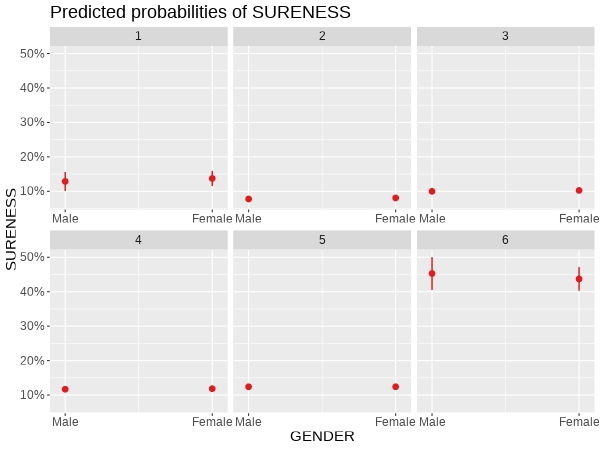

In [20]:
%%R -w 600 -h 450 -u px
# Plot marginal effects
plot_model(m_03, type = "pred", terms = c("GENDER"))

#### Model Performance

We can evaluate the performance of the mixed-effects multinomial model using the `performance()` function from the {performance} package. This function provides various performance metrics such as the AIC, BIC, and log-likelihood of the model.



In [21]:
%%R
performance::performance(m_03)

Can't calculate log-loss.


  cumulative link models.



# Indices of model performance

AIC      |      BIC | R2 (cond.) | R2 (marg.) |  RMSE | Sigma
-------------------------------------------------------------
5538.631 | 5571.759 |      0.246 |      0.100 | 4.403 | 4.410


## Summary and Conclusion

Mixed-effects ordinal regression models are an enhanced version of ordinal regression that accommodates hierarchical or grouped data structures. These models are particularly beneficial when the response variable is ordinal (i.e., consists of ordered categories) and when the data include random effects, such as measurements taken from multiple individuals or groups. The cumulative link mixed model (CLMM), which can be implemented using the `clmm()` function from the {ordinal} package in R, allows for the modeling of ordinal data with both fixed and random effects. This tutorial is a foundation for applying mixed-effects ordinal regression in real-world scenarios, enabling researchers to draw meaningful conclusions from hierarchical ordinal data.

## References

1.  [Ordinal logistic regression](https://www.bookdown.org/rwnahhas/RMPH/blr-ordinal.html)

2.  [Mixed-Effects Ordinal Regression](https://ladal.edu.au/regression.html#Mixed-Effects_Ordinal_Regression)

3.  [Mixed Models for Ordinal Data](https://drizopoulos.github.io/GLMMadaptive/articles/Ordinal_Mixed_Models.html)



